# Интерпретация. Практическая работа

## Цель практической работы

Научиться интерпретировать модели кластеризации.

## Что входит в практическую работу


1. Загрузить данные и провести разведочный анализ.
2. Предположить оптимальное количество кластеров.
3. Очистить и подготовить данные для использования в моделях машинного обучения.
4. Построить модель кластеризации с помощью библиотеки Scikit-learn и вычислить оптимальное количество кластеров.
5. Визуализировать результаты кластеризации.
6. Интерпретировать полученные результаты.
7. Подкрепить выводы интерпретации визуализациями.

## Что оценивается 

* Выполнены все этапы работы.
* Сделаны выводы по результатам разведочного анализа данных.
* Выполнена и обоснована подготовка данных.
* Выбор количества кластеров обоснован и подкреплён визуализацией. 
* Выбор гиперпараметров метода понижения размерности обоснован.
* Интерпретация кластеров подкреплена расчётами и визуализацией. 



# Задача

У вас имеется некоторый набор данных `marketing_campaign.csv` о покупателях супермаркета.

* ID — уникальный идентификатор клиента.
* Year_Birth — год рождения клиента.
* Dt_Customer — дата регистрации клиента на сайте.
* Recency — количество дней с момента последней покупки клиента.
* MntFruits — сумма, потраченная на фрукты за последние два года.
* MntMeatProducts — сумма, потраченная на мясо за последние два года.
* MntFishProducts — сумма, потраченная на рыбу за последние два года.
* MntSweetProducts — сумма, потраченная на сладости за последние два года.
* NumWebPurchases — количество покупок, совершённых через сайт.
* NumStorePurchases — количество покупок, совершённых непосредственно в магазинах.
* Response: 1, если клиент участвовал в последней рекламной кампании, 0 — в противном случае.

Решите задачу кластеризации покупателей, чтобы в дальнейшем планировать маркетинговые акции для каждой группы покупателей. Подготовьте результаты своей работы для демонстрации заказчику, не погружённому в машинное обучение.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

from IPython.display import display

# Задание 1

Загрузите датасет и выполните разведочный анализ данных. Сделайте выводы о найденных закономерностях, особенностях и других свойствах данных, которые вы обнаружите.

In [2]:
df = pd.read_csv('data/marketing campaign.csv')
#df_to_interprit = df.copy()
print(df.shape)
df.head(5)

(2240, 11)


,ID,Year_Birth,Dt_Customer,Recency,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,NumWebPurchases,NumStorePurchases,Response
0,5524,1957,04-09-2012,58,88,546,172,88,8,4,1
1,2174,1954,08-03-2014,38,1,6,2,1,1,2,0
2,4141,1965,21-08-2013,26,49,127,111,21,8,10,0
3,6182,1984,10-02-2014,26,4,20,10,3,2,4,0
4,5324,1981,19-01-2014,94,43,118,46,27,5,6,0


In [3]:
print(df.shape)
print(df.columns)
print(df.dtypes)

(2240, 11)
Index(['ID', 'Year_Birth', 'Dt_Customer', 'Recency', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'NumWebPurchases', 'NumStorePurchases', 'Response'],
      dtype='object')
ID                    int64
Year_Birth            int64
Dt_Customer          object
Recency               int64
MntFruits             int64
MntMeatProducts       int64
MntFishProducts       int64
MntSweetProducts      int64
NumWebPurchases       int64
NumStorePurchases     int64
Response              int64
dtype: object


In [4]:
# Приведем значения Dt_Customer к типу DATETIME
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], dayfirst=True)

print(df.dtypes)

ID                            int64
Year_Birth                    int64
Dt_Customer          datetime64[ns]
Recency                       int64
MntFruits                     int64
MntMeatProducts               int64
MntFishProducts               int64
MntSweetProducts              int64
NumWebPurchases               int64
NumStorePurchases             int64
Response                      int64
dtype: object


In [5]:
# Получаем количество пропусков
missing_values = df.isna().sum()
# Получаем процент пропусков
missing_percentage = (missing_values / df.shape[0]) * 100
# Объединяем в один DataFrame
missing_info = pd.DataFrame({
    'Количество пропусков': missing_values,
    'Процент пропусков': missing_percentage
})
# Создаем переменную с пропусками
missing_info = missing_info[missing_info['Количество пропусков'] > 0]
print(missing_info)

Empty DataFrame
Columns: [Количество пропусков, Процент пропусков]
Index: []


<Axes: >

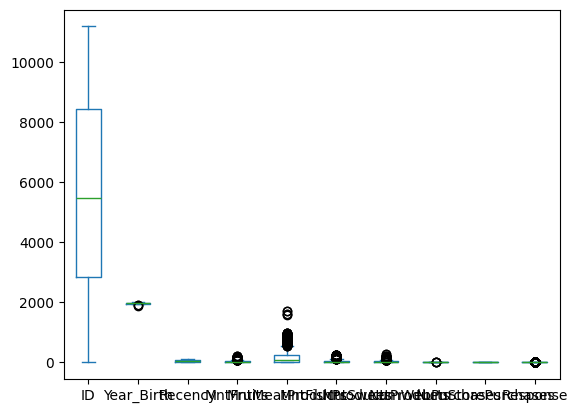

In [6]:
# Предварительно глянем на признаки
df.plot(kind='box')

#### Посмотрим на признаки более детально

In [7]:

def calculate_iqr_boundaries(series: pd.Series) -> tuple:
    """
    Вычисляет границы выбросов на основе межквартильного размаха (IQR).

    :param series: pandas Series, для которой вычисляются границы
    :return: кортеж (нижняя граница, верхняя граница)
    """
    if series.empty:
        raise ValueError("Входная серия не должна быть пустой.")

    q25 = series.quantile(0.25)
    q75 = series.quantile(0.75)
    iqr = q75 - q25

    boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)
    return boundaries

====== Year_Birth =====
Размах (1932.0, 2004.0)
Количество выбросов 3 0


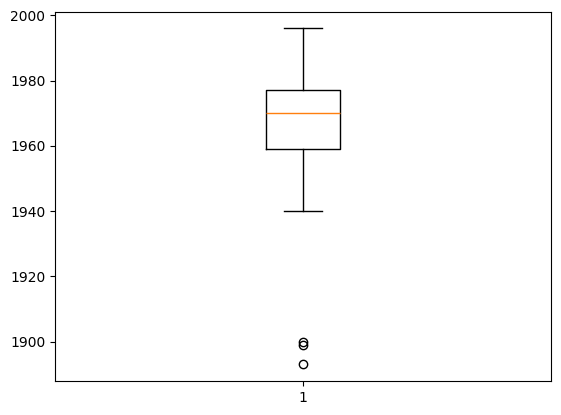

Количество значений 2240
count    2240.000000
mean     1968.805804
std        11.984069
min      1893.000000
25%      1959.000000
50%      1970.000000
75%      1977.000000
max      1996.000000
Name: Year_Birth, dtype: float64
=======+++++++=======
====== Recency =====
Размах (-51.0, 149.0)
Количество выбросов 0 0


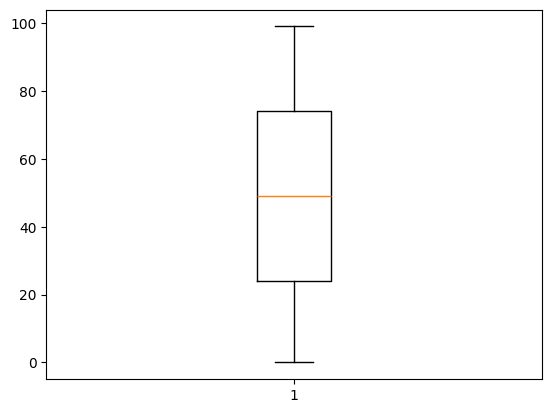

Количество значений 2240
count    2240.000000
mean       49.109375
std        28.962453
min         0.000000
25%        24.000000
50%        49.000000
75%        74.000000
max        99.000000
Name: Recency, dtype: float64
=======+++++++=======
====== MntFruits =====
Размах (-47.0, 81.0)
Количество выбросов 0 227


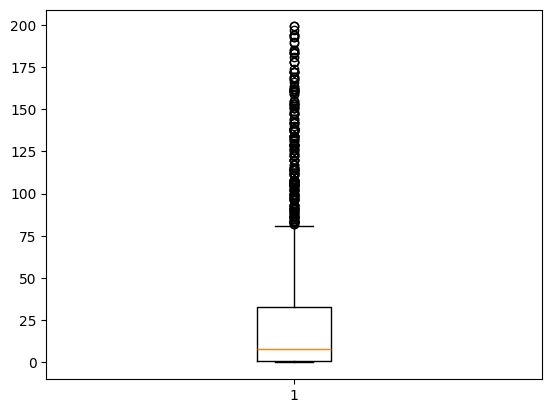

Количество значений 2240
count    2240.000000
mean       26.302232
std        39.773434
min         0.000000
25%         1.000000
50%         8.000000
75%        33.000000
max       199.000000
Name: MntFruits, dtype: float64
=======+++++++=======
====== MntMeatProducts =====
Размах (-308.0, 556.0)
Количество выбросов 0 175


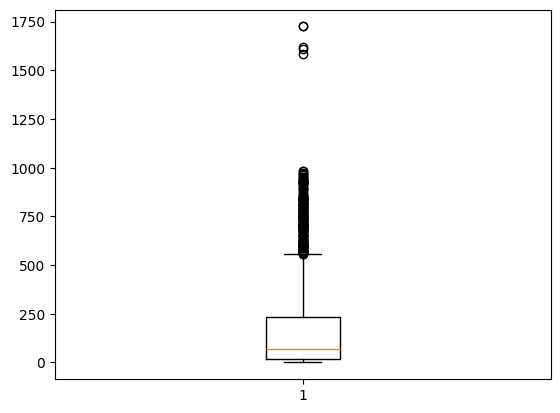

Количество значений 2240
count    2240.000000
mean      166.950000
std       225.715373
min         0.000000
25%        16.000000
50%        67.000000
75%       232.000000
max      1725.000000
Name: MntMeatProducts, dtype: float64
=======+++++++=======
====== MntFishProducts =====
Размах (-67.5, 120.5)
Количество выбросов 0 223


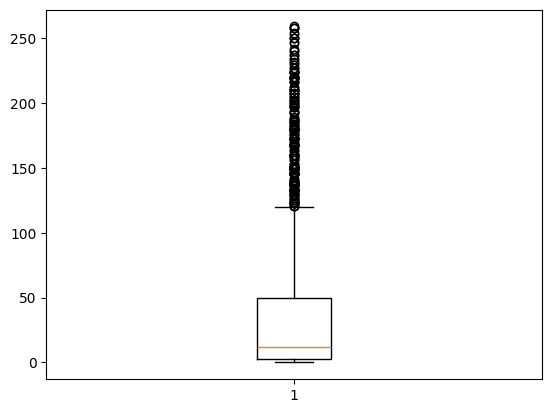

Количество значений 2240
count    2240.000000
mean       37.525446
std        54.628979
min         0.000000
25%         3.000000
50%        12.000000
75%        50.000000
max       259.000000
Name: MntFishProducts, dtype: float64
=======+++++++=======
====== MntSweetProducts =====
Размах (-47.0, 81.0)
Количество выбросов 0 248


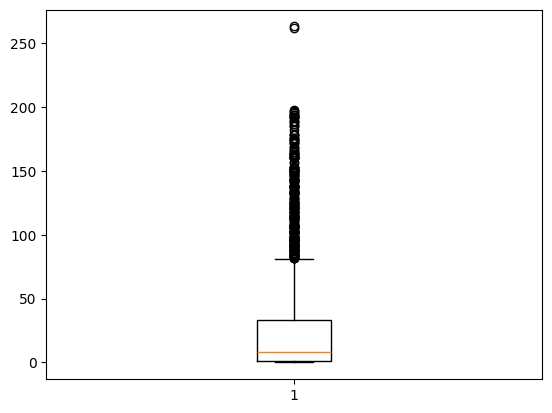

Количество значений 2240
count    2240.000000
mean       27.062946
std        41.280498
min         0.000000
25%         1.000000
50%         8.000000
75%        33.000000
max       263.000000
Name: MntSweetProducts, dtype: float64
=======+++++++=======
====== NumWebPurchases =====
Размах (-4.0, 12.0)
Количество выбросов 0 4


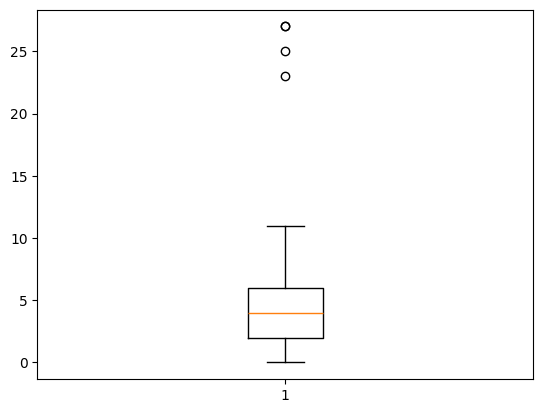

Количество значений 2240
count    2240.000000
mean        4.084821
std         2.778714
min         0.000000
25%         2.000000
50%         4.000000
75%         6.000000
max        27.000000
Name: NumWebPurchases, dtype: float64
=======+++++++=======
====== NumStorePurchases =====
Размах (-4.5, 15.5)
Количество выбросов 0 0


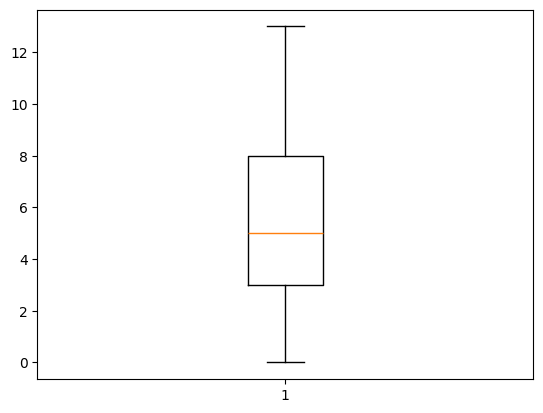

Количество значений 2240
count    2240.000000
mean        5.790179
std         3.250958
min         0.000000
25%         3.000000
50%         5.000000
75%         8.000000
max        13.000000
Name: NumStorePurchases, dtype: float64
=======+++++++=======
====== Response =====
Размах (0.0, 0.0)
Количество выбросов 0 334


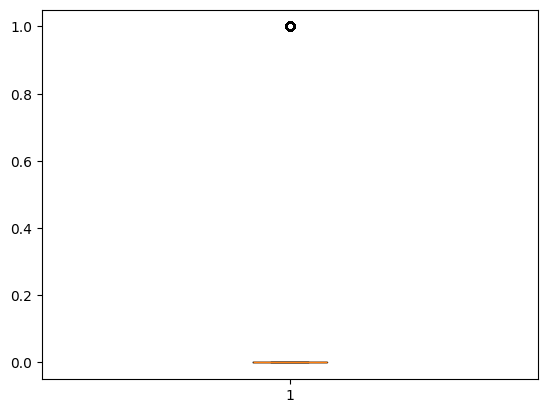

Количество значений 2240
count    2240.000000
mean        0.149107
std         0.356274
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: Response, dtype: float64
=======+++++++=======


In [8]:
num_cols = df.select_dtypes(include=['number']).drop(['ID'], axis=1)
num_cols_list = num_cols.columns
for i in num_cols_list:
    print('======', i, '=====')
    bounds = calculate_iqr_boundaries(df[i])
    out_l = sum(df[i] < bounds[0])
    out_r = sum(df[i] > bounds[1])
    print('Размах', bounds)
    print('Количество выбросов', out_l, out_r)
    plt.boxplot(df[i])
    plt.show()
    print('Количество значений', sum(df[i].value_counts()))
    print(df[i].describe())
    print('=======+++++++=======')

#### Посмотрим на закономерности между признаками

In [9]:
#sns.pairplot(df)
#plt.show()

# Задание 2

Метод k-средних требует явно задать количество кластеров, на которые будут разбиваться данные. Данных может быть так много, что построение одной модели будет занимать несколько часов, поэтому важно заранее примерно представлять количество кластеров до запуска обучения модели.

На основе проведённого разведочного анализа данных предположите, какое количество кластеров будет оптимальным, аргументируйте своё предположение.

<Axes: >

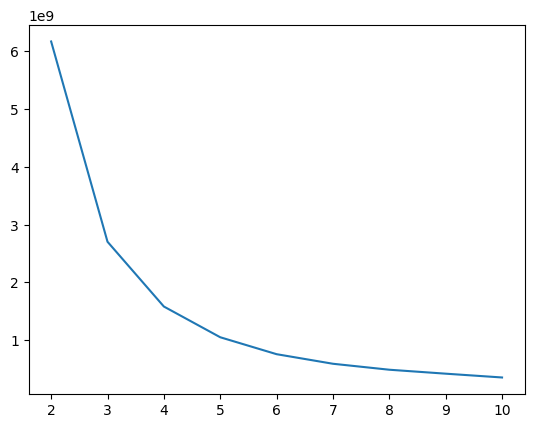

In [10]:
# Как наиболее простой и быстрый предварительный вариант предполажения количества кластеров
# Представляется использование
# метода локтя и инерции

n_clusters = list(range(2, 11))
x = df.drop(['Dt_Customer'], axis=1)
metrics = []

for k in n_clusters:
  km = KMeans(n_clusters=k).fit(x)
  metrics.append(km.inertia_)

sns.lineplot(x=n_clusters, y=metrics)

Напишите ваш ответ ниже


In [11]:
# Предварительно ДО очистки и нормализации данных предполагается три кластера

# Задание 3

Выполните очистку и подготовку данных для дальнейшего использования при построении моделей машинного обучения. Аргументируйте выбранные шаги подготовки данных. 

In [12]:
# посмотрим дубликаты
df[df.duplicated()]

,ID,Year_Birth,Dt_Customer,Recency,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,NumWebPurchases,NumStorePurchases,Response


In [13]:
# Получаем количество пропусков
missing_values = df.isna().sum()
missing_percentage = (missing_values / df.shape[0]) * 100
# Объединяем в один DataFrame
missing_info = pd.DataFrame({
    'Количество пропусков': missing_values,
    'Процент пропусков': missing_percentage
})

missing_info = missing_info[missing_info['Количество пропусков'] > 0]
print(missing_info)

Empty DataFrame
Columns: [Количество пропусков, Процент пропусков]
Index: []


#### Пропусков в данных нет, поэтому сначала займемся Признаком Dt_Customer с типом datetime

до нормализации числовых признаков

In [14]:
# изначально предположим получить следующие признаки:
# Weekday 
# Season 
# Days_Action

In [15]:
# Создание признака: день недели
df['Weekday'] = df['Dt_Customer'].dt.day_name()

# Преобразование дней недели в числовые значения
weekday_mapping = {
    'Monday': 0,
    'Tuesday': 1,
    'Wednesday': 2,
    'Thursday': 3,
    'Friday': 4,
    'Saturday': 5,
    'Sunday': 6
}

# Применение преобразования
df['Weekday'] = df['Weekday'].map(weekday_mapping)

In [16]:
# Создание признака: время года
# Определяем функцию, чтобы получить время года на основе месяца
def get_season(month):
    if month in [12, 1, 2]:
        return 1
    elif month in [3, 4, 5]:
        return 2
    elif month in [6, 7, 8]:
        return 3
    else:
        return 4

df['Season'] = df['Dt_Customer'].dt.month.apply(get_season)

In [17]:
# Создание признака: давность совершения действия (в днях от даты 10 лет назад)
date_10_years_ago = pd.to_datetime('now') - pd.DateOffset(years=11)
df['Days_Action'] = (date_10_years_ago - df['Dt_Customer']).dt.days


In [18]:
# Создание признака: давность совершения действия (в днях от текущей даты)
#df['Days_Action'] = (pd.to_datetime('now') - df['Dt_Customer']).dt.days

# Проверка результатов
print(df[['Dt_Customer', 'Weekday', 'Season', 'Days_Action']].head())

  Dt_Customer  Weekday  Season  Days_Action
0  2012-09-04        1       4          363
1  2014-03-08        5       2         -187
2  2013-08-21        2       3           12
3  2014-02-10        0       1         -161
4  2014-01-19        6       1         -139


In [19]:
df.columns

Index(['ID', 'Year_Birth', 'Dt_Customer', 'Recency', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'NumWebPurchases', 'NumStorePurchases', 'Response', 'Weekday', 'Season',
       'Days_Action'],
      dtype='object')

In [20]:
# оставим! признак Dt_Customer он пригодится для интерпретации результатов
df = df.drop(['ID'], axis=1)
df.dtypes

Year_Birth                    int64
Dt_Customer          datetime64[ns]
Recency                       int64
MntFruits                     int64
MntMeatProducts               int64
MntFishProducts               int64
MntSweetProducts              int64
NumWebPurchases               int64
NumStorePurchases             int64
Response                      int64
Weekday                       int64
Season                        int64
Days_Action                   int64
dtype: object

#### Поработаем с выбросами

In [21]:
num_cols_list = df.columns.drop(['Dt_Customer'])
for i in num_cols_list:
    print('======', i, '=====')
    bounds = calculate_iqr_boundaries(df[i])
    out_l = df[df[i] < bounds[0]]  # Строки с левыми выбросами
    out_r = df[df[i] > bounds[1]]  # Строки с правыми выбросами

    print('Размах', bounds)
    print('Количество выбросов слева:', len(out_l))
    print('Количество выбросов справа:', len(out_r))
    print('Общее количество значений:', sum(df[i].value_counts()))

    if not out_l.empty:
        print('Выбросы слева:')
        print(out_l)

    if not out_r.empty:
        print('Выбросы справа:')
        print(out_r)
    
    print('=======+++++++=======') 


====== Year_Birth =====
Размах (1932.0, 2004.0)
Количество выбросов слева: 3
Количество выбросов справа: 0
Общее количество значений: 2240
Выбросы слева:
     Year_Birth Dt_Customer  Recency  MntFruits  MntMeatProducts  \
192        1900  2013-09-26       99          6                8   
239        1893  2014-05-17       23          0                5   
339        1899  2013-09-26       36        144              562   

     MntFishProducts  MntSweetProducts  NumWebPurchases  NumStorePurchases  \
192                7                 4                2                  2   
239                7                 0                1                  2   
339              104                64                4                  4   

     Response  Weekday  Season  Days_Action  
192         0        3       4          -24  
239         0        5       2         -257  
339         0        3       4          -24  
=======+++++++=======
====== Recency =====
Размах (-51.0, 149.0)
Количество 

In [22]:
# Заменим выбросы граничными значениями и сразу проверим результат

num_cols_list = df.columns.drop(['Dt_Customer'])
for i in num_cols_list:
    print('======', i, '=====')
    lower_bound, upper_bound = calculate_iqr_boundaries(df[i])
    
    out_l = df[df[i] < lower_bound]  # Строки с левыми выбросами
    out_r = df[df[i] > upper_bound]  # Строки с правыми выбросами

  

    # ИЛИ МЕДИАНУ
    median_income = df[i].median()
    # Заменяем выбросы на медиану
    df[i] = df[i].apply(lambda x: median_income if x < lower_bound or x > upper_bound else x)

    # Заменяем выбросы на граничные значения
    df[i] = df[i].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))


    # После замены, пересчитываем границы
    lower_bound, upper_bound = calculate_iqr_boundaries(df[i])
    
    # Проверяем оставшиеся выбросы
    out_l = df[df[i] < lower_bound]  # Строки с левыми выбросами
    out_r = df[df[i] > upper_bound]  # Строки с правыми выбросами

    print('Размах', (lower_bound, upper_bound))
    print('Количество выбросов слева:', len(out_l))
    print('Количество выбросов справа:', len(out_r))
    print('Общее количество значений:', sum(df[i].value_counts()))

    if not out_l.empty:
        print('Выбросы слева:')
        print(out_l)

    if not out_r.empty:
        print('Выбросы справа:')
        print(out_r)

    print('=======+++++++=======')


====== Year_Birth =====
Размах (1932.0, 2004.0)
Количество выбросов слева: 0
Количество выбросов справа: 0
Общее количество значений: 2240
=======+++++++=======
====== Recency =====
Размах (-51.0, 149.0)
Количество выбросов слева: 0
Количество выбросов справа: 0
Общее количество значений: 2240
=======+++++++=======
====== MntFruits =====
Размах (-26.0, 46.0)
Количество выбросов слева: 0
Количество выбросов справа: 202
Общее количество значений: 2240
Выбросы справа:
      Year_Birth Dt_Customer  Recency  MntFruits  MntMeatProducts  \
2         1965.0  2013-08-21       26       49.0              127   
6         1971.0  2012-11-13       34       65.0              164   
12        1959.0  2013-11-15       82       61.0              480   
18        1949.0  2013-03-28       91       80.0              498   
40        1980.0  2013-04-29        3       76.0              536   
...          ...         ...      ...        ...              ...   
2193      1957.0  2012-11-06       38       54.

#### Закодируем числовые признаки

In [23]:
# уберем как оказалось ненужные признаки

df.drop(['Dt_Customer', 'Weekday', 'Season', 'Days_Action'], axis=1, inplace=True)

In [24]:
df_to_interprit = df.copy()

Histogram for Year_Birth


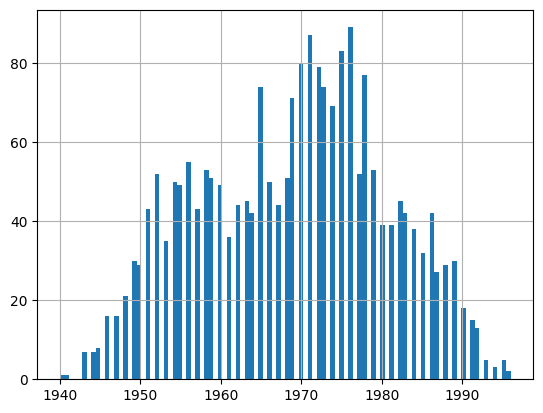

Histogram for Recency


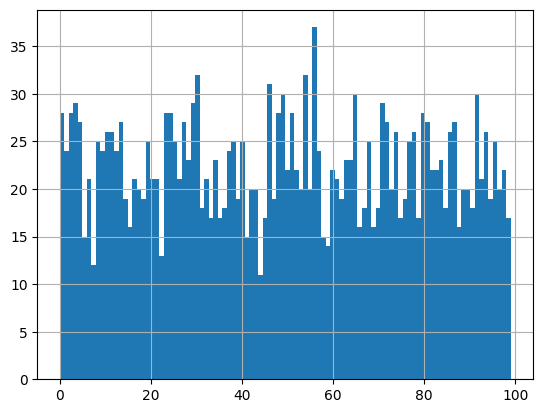

Histogram for MntFruits


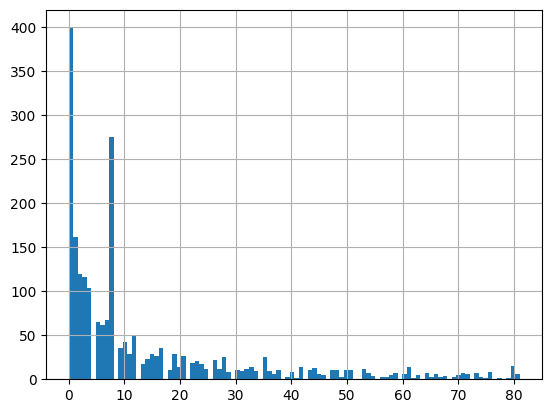

Histogram for MntMeatProducts


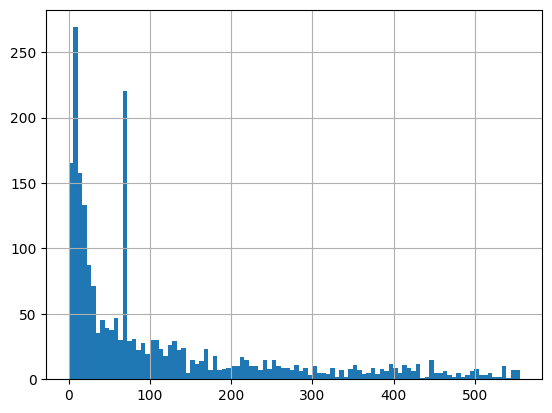

Histogram for MntFishProducts


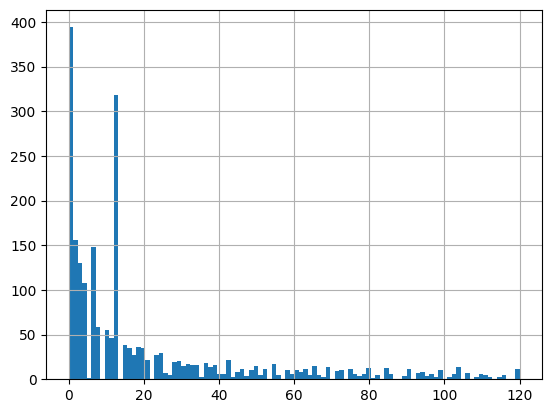

Histogram for MntSweetProducts


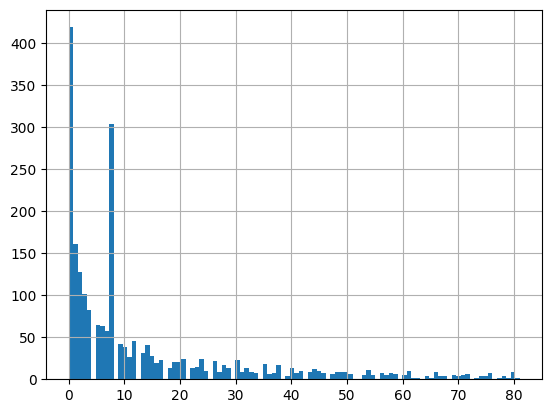

Histogram for NumWebPurchases


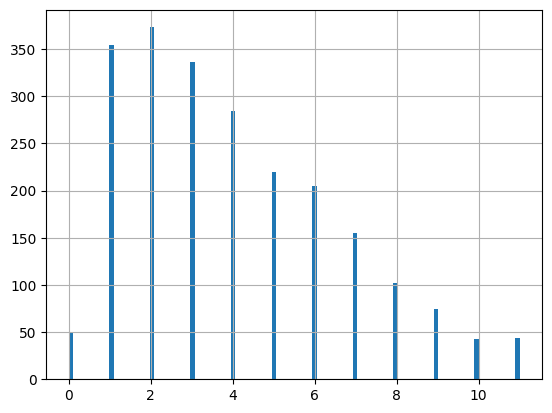

Histogram for NumStorePurchases


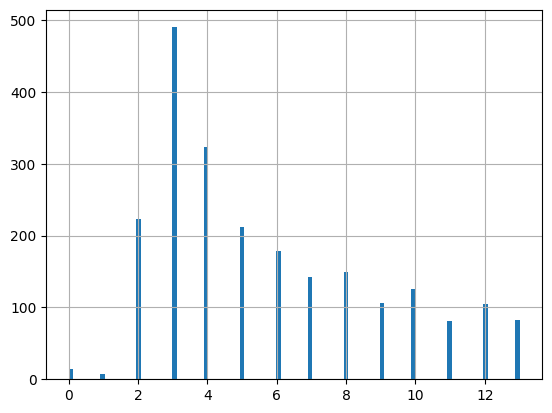

Histogram for Response


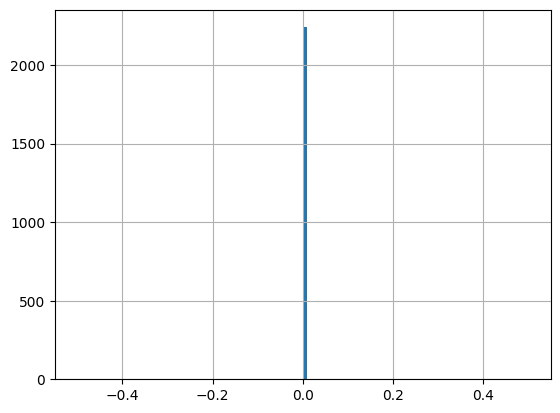

In [25]:
# Посмотрим распределения признаков после обработки выбросов
num_cols = df.select_dtypes(include=['number'])
for col in num_cols:
  print(f'Histogram for {col}')
  df[col].hist(bins=100)
  plt.show()

In [26]:
unique_counts = df.nunique()
print(unique_counts)

Year_Birth            56
Recency              100
MntFruits             80
MntMeatProducts      421
MntFishProducts       99
MntSweetProducts      81
NumWebPurchases       12
NumStorePurchases     14
Response               1
dtype: int64


Для численных признаков с нормальным распределением: выбирайте StandardScaler. Это лучше всего подходит для KMeans, поскольку алгоритм чувствителен к расстояниям между точками.

Для численных признаков с неограниченными диапазонами и отсутствием нормального распределения, а также для признаков, которые должны быть в строгом диапазоне (например, вероятности): лучше использовать MinMaxScaler.

In [27]:
# Применяем StandardScaler к признаку Year_Birth
st_scaler = StandardScaler()
df['Year_Birth'] = st_scaler.fit_transform(df[['Year_Birth']])
df

,Year_Birth,Recency,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,NumWebPurchases,NumStorePurchases,Response
0,-1.018098,58,8.0,546.0,12.0,8.0,8.0,4,0.0
1,-1.274694,38,1.0,6.0,2.0,1.0,1.0,2,0.0
2,-0.333842,26,49.0,127.0,111.0,21.0,8.0,10,0.0
3,1.291266,26,4.0,20.0,10.0,3.0,2.0,4,0.0
4,1.034670,94,43.0,118.0,46.0,27.0,5.0,6,0.0
...,...,...,...,...,...,...,...,...,...
2235,-0.162778,46,43.0,182.0,42.0,8.0,9.0,4,0.0
2236,-1.958950,56,0.0,30.0,0.0,0.0,8.0,5,0.0
2237,1.034670,91,48.0,217.0,32.0,12.0,2.0,13,0.0
2238,-1.103630,8,30.0,214.0,80.0,30.0,6.0,10,0.0


In [28]:
mm_scaler = MinMaxScaler()
# Применение MinMaxScaler к нужным признакам

to_minmax = ['Recency', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'NumWebPurchases',
       'NumStorePurchases', 'Response']

df[to_minmax] = mm_scaler.fit_transform(df[to_minmax])
df

,Year_Birth,Recency,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,NumWebPurchases,NumStorePurchases,Response
0,-1.018098,0.585859,0.098765,0.983784,0.100000,0.098765,0.727273,0.307692,0.0
1,-1.274694,0.383838,0.012346,0.010811,0.016667,0.012346,0.090909,0.153846,0.0
2,-0.333842,0.262626,0.604938,0.228829,0.925000,0.259259,0.727273,0.769231,0.0
3,1.291266,0.262626,0.049383,0.036036,0.083333,0.037037,0.181818,0.307692,0.0
4,1.034670,0.949495,0.530864,0.212613,0.383333,0.333333,0.454545,0.461538,0.0
...,...,...,...,...,...,...,...,...,...
2235,-0.162778,0.464646,0.530864,0.327928,0.350000,0.098765,0.818182,0.307692,0.0
2236,-1.958950,0.565657,0.000000,0.054054,0.000000,0.000000,0.727273,0.384615,0.0
2237,1.034670,0.919192,0.592593,0.390991,0.266667,0.148148,0.181818,1.000000,0.0
2238,-1.103630,0.080808,0.370370,0.385586,0.666667,0.370370,0.545455,0.769231,0.0


# Задание 4

Постройте модель кластеризации с помощью метода k-средних. Определите оптимальное количество кластеров с помощью метода локтя и метрики silhouette score. 

Помните, что аналитический способ определения количества кластеров не является единственно верным. Если ваше понимание предметной области и результаты анализа данных расходятся с результатами метода локтя, вы можете выбрать и обосновать количество кластеров, исходя из своего опыта.

In [29]:
# посмотрим на призаки на подготовленных данных
#sns.pairplot(df)
#plt.show()

In [30]:
x = df

<Axes: >

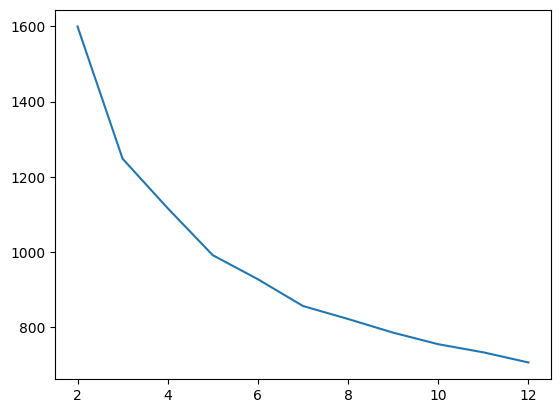

In [31]:
# Как наиболее простой и быстрый предварительный вариант предполажения количества кластеров
# Представляется использование
# метода локтя и инерции

n_clusters = list(range(2, 13))
x = df
metrics = []

for k in n_clusters:
  km = KMeans(n_clusters=k).fit(x)
  metrics.append(km.inertia_)

sns.lineplot(x=n_clusters, y=metrics)

max_score 0.4030795436249059
max_index 0
clusters 2


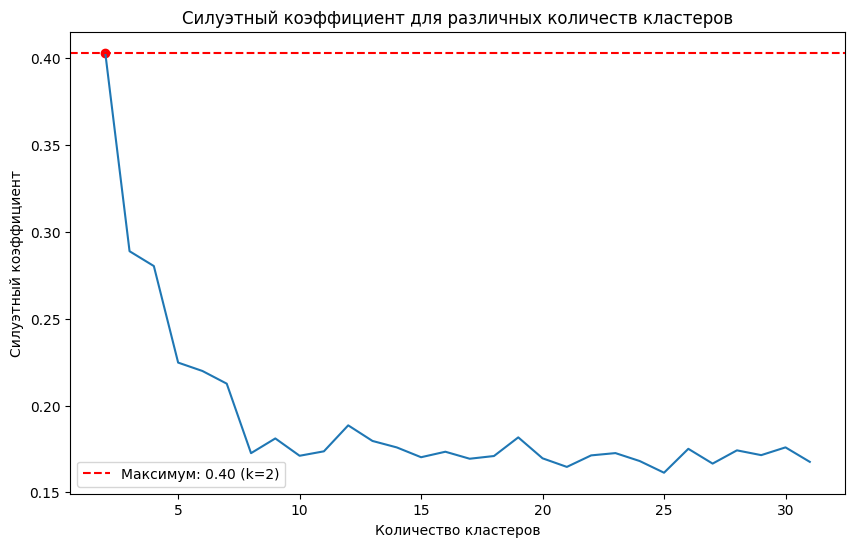

In [32]:

# Настройки для кластеризации
n_clusters = list(range(2, 32))
metrics = []

# Вычисляем силуэтный коэффициент для разных количеств кластеров
for k in n_clusters:
    km = KMeans(n_clusters=k).fit(x)
    score = silhouette_score(x, km.labels_)
    metrics.append(score)

# Находим максимальное значение и его индекс
max_score = max(metrics)
max_index = metrics.index(max_score)
optimal_clusters = n_clusters[max_index]

print('max_score', max_score)
print('max_index', max_index)
print('clusters', optimal_clusters)

# Визуализация результатов
plt.figure(figsize=(10, 6))
sns.lineplot(x=n_clusters, y=metrics)
plt.axhline(y=max_score, color='r', linestyle='--', label='Максимум: {:.2f} (k={})'.format(max_score, optimal_clusters))
plt.scatter(optimal_clusters, max_score, color='red')  # красная точка на максимуме
plt.title('Силуэтный коэффициент для различных количеств кластеров')
plt.xlabel('Количество кластеров')
plt.ylabel('Силуэтный коэффициент')
plt.legend()
plt.show()

In [33]:
# в локте смотрим перелом

# в силуэте выбираем максимум функции

In [34]:
km = KMeans(n_clusters=4, random_state=42)
km.fit(x)
points = km.predict(x)

# Задание 5

Визуализируйте результаты кластеризации на двумерном графике с помощью метода t-SNE. Обоснуйте выбранные значения его гиперпараметров.

In [35]:
labels = km.labels_

In [36]:
tsne = TSNE(n_components=2, perplexity=30)
df_emb = tsne.fit_transform(x)
data = pd.DataFrame(df_emb)
data

,0,1
0,36.993694,20.780787
1,37.904613,-24.792122
2,11.540119,31.465851
3,-55.708412,-6.868780
4,-24.123920,27.484612
...,...,...
2235,10.106058,28.291965
2236,60.242989,3.238623
2237,-21.235807,23.849226
2238,40.361778,26.729773


<Axes: xlabel='0', ylabel='1'>

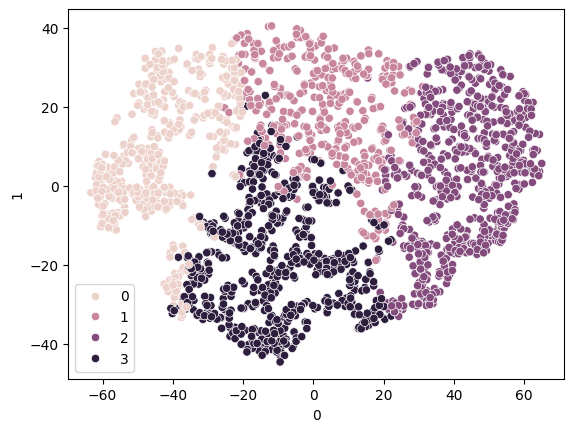

In [37]:
sns.scatterplot(x=data[0], y=data[1], hue=labels)


# Задание 6

Постройте профили кластеров и опишите их.

In [38]:
# Создаем доп признак с предиктом
df['Cluster'] = km.fit_predict(df)

In [39]:
# Получение центроидов
centroids = km.cluster_centers_

In [40]:
# Обратное преобразование центроидов
centroids_df = pd.DataFrame(centroids, columns=df.columns[:-1])  # Убираем 'Cluster'

In [41]:
# Обратное преобразование для Year_Birth и признаков в MinMax
centroids_df['Year_Birth'] = st_scaler.inverse_transform(centroids_df[['Year_Birth']])
centroids_df[to_minmax] = mm_scaler.inverse_transform(centroids_df[to_minmax])

In [42]:
# Описание типичных представителей каждой группы
cluster_descriptions = []

for i in range(centroids_df.shape[0]):
    cluster_description = centroids_df.iloc[i].astype(int)  # Приведение к целым числам
    cluster_descriptions.append([f"Кластер {i}"] + cluster_description.tolist())

# Создание нового DataFrame для отображения
cluster_df = pd.DataFrame(cluster_descriptions, columns=["Кластер"] + centroids_df.columns.tolist())

cluster_df

,Кластер,Year_Birth,Recency,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,NumWebPurchases,NumStorePurchases,Response
0,Кластер 0,1984,47,14,112,21,15,3,5,0
1,Кластер 1,1969,50,26,206,41,24,6,8,0
2,Кластер 2,1954,49,16,131,23,15,4,6,0
3,Кластер 3,1972,48,4,31,6,4,2,3,0


* Year_Birth — год рождения клиента.

* Recency — количество дней с момента последней покупки клиента.
* MntFruits — сумма, потраченная на фрукты за последние два года.
* MntMeatProducts — сумма, потраченная на мясо за последние два года.
* MntFishProducts — сумма, потраченная на рыбу за последние два года.
* MntSweetProducts — сумма, потраченная на сладости за последние два года.
* NumWebPurchases — количество покупок, совершённых через сайт.
* NumStorePurchases — количество покупок, совершённых непосредственно в магазинах.
* Response: 1, если клиент участвовал в последней рекламной кампании, 0 — в противном случае.

In [43]:
print(df_to_interprit['Year_Birth'].mean().round(2))
print(df_to_interprit['Recency'].mean().round(2))
print(df_to_interprit['MntFruits'].mean().round(2))
print(df_to_interprit['MntMeatProducts'].mean().round(2))
print(df_to_interprit['MntFishProducts'].mean().round(2))
print(df_to_interprit['MntSweetProducts'].mean().round(2))

print(df_to_interprit['NumWebPurchases'].mean().round(2))
print(df_to_interprit['NumStorePurchases'].mean().round(2))

1968.9
49.11
14.28
112.67
21.31
13.86
4.05
5.79


Кластер 0:

1984 года рождения                           среднее  1969    возраст меньше среднего

47 дней с момента последней покупки          среднее  49      немного ниже среднего

14 потрачено на фрукты                       среднее  14      потрачено на фрукты среднее

112 потрачено на мясо                        среднее  113     потрачено на мясо около среднего

21 потрачено на рыбу                         среднее  21      потрачено на рыбу около среднего

15 потрачено на сладкое                      среднее  13      потрачено на сладкое выше среднего

3 покупок с сайта                            среднее  4       покупок с сайта меньше среднего

5 покупок в магазине                         среднее  6       покупок в магазине около среднего

в рекламной компании не учавствовал


Кластер 1:

1969 года рождения                           среднее  1968    возраст больше среднего

50 дней с момента последней покупки          среднее  49      среднее

26 потрачено на фрукты                       среднее  21      потрачено на фрукты значительно ниже среднего

206 потрачено на мясо                        среднее  150     потрачено на мясо значительно больше среднего

41 потрачено на рыбу                         среднее  32      потрачено на рыбу больше среднего

24 потрачено на сладкое                      среднее  22      потрачено на сладкое немного выше среднего

6 покупок с сайта                            среднее  4       покупок с сайта больше среднего

8 покупок в магазине                         среднее  6       покупок в магазине выше среднего

в рекламной компании не учавствовал

Кластер 2:

1954 года рождения                           среднее  1968    возраст больше среднего

49 дней с момента последней покупки          среднее  49      среднее

16  потрачено на фрукты                      среднее  21      потрачено на фрукты ниже среднего

131  потрачено на мясо                       среднее  150     потрачено на мясо ниже среднего

23  потрачено на рыбу                        среднее  32      потрачено на рыбу ниже среднего

15  потрачено на сладкое                     среднее  22      потрачено на сладкое ниже среднего

4 покупок с сайта                            среднее  4       покупок с сайта среднее

6 покупок в магазине                         среднее  6       покупок в магазине среднее

в рекламной компании не учавствовал

Кластер 3:

1972 года рождения                           среднее  1968    возраст меньше среднего

48 дней с момента последней покупки          среднее  49      среднее

4 потрачено на фрукты                        среднее  21      потрачено на фрукты значительно меньше среднего

31 потрачено на мясо                         среднее  150     потрачено на мясо значительно меньше среднего

6 потрачено на рыбу                          среднее  32      потрачено на рыбу значительно меньше среднего

4 потрачено на сладкое                       среднее  22      потрачено на сладкое значительно меньше среднего

2 покупок с сайта                            среднее  4       покупок с сайта значительно ниже среднего

3 покупок в магазине                         среднее  6       покупок в магазине значительно ниже среднего

в рекламной компании не учавствовал

# Задание 7

Визуализируйте профили кластеров. Подготовьте краткое резюме результатов вашего исследования для заказчика.

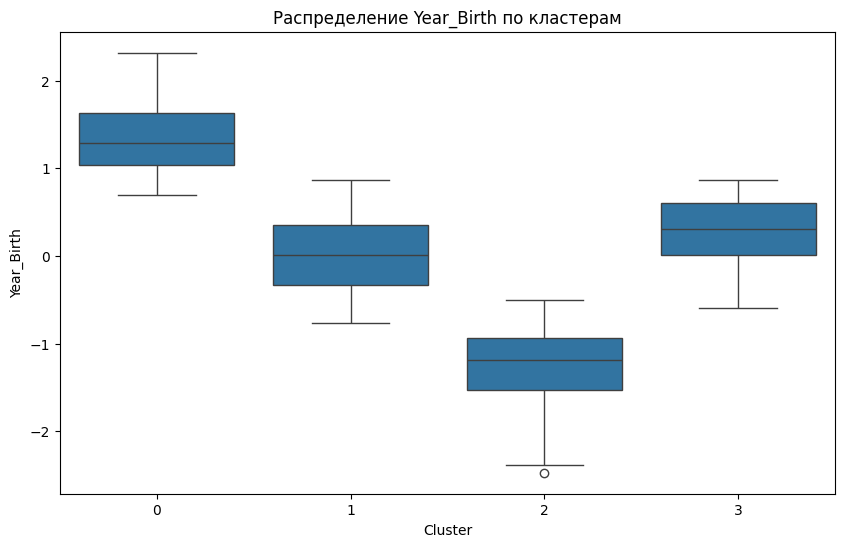

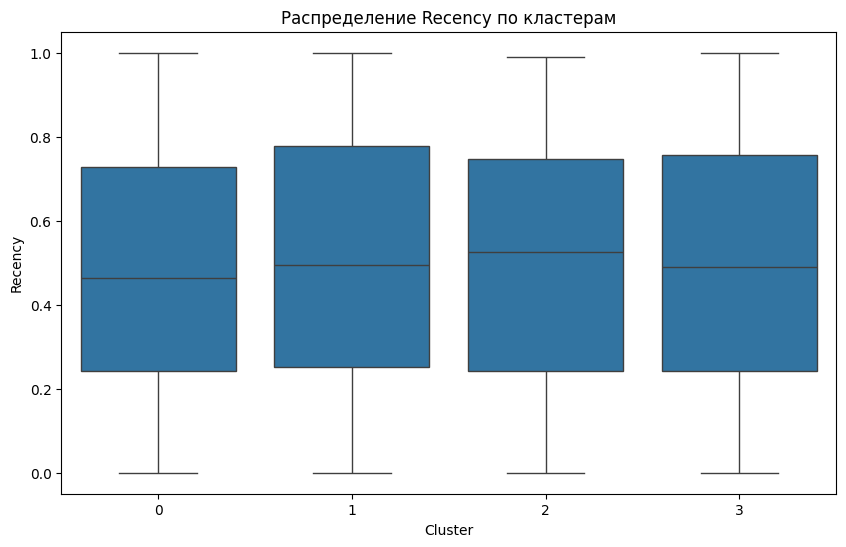

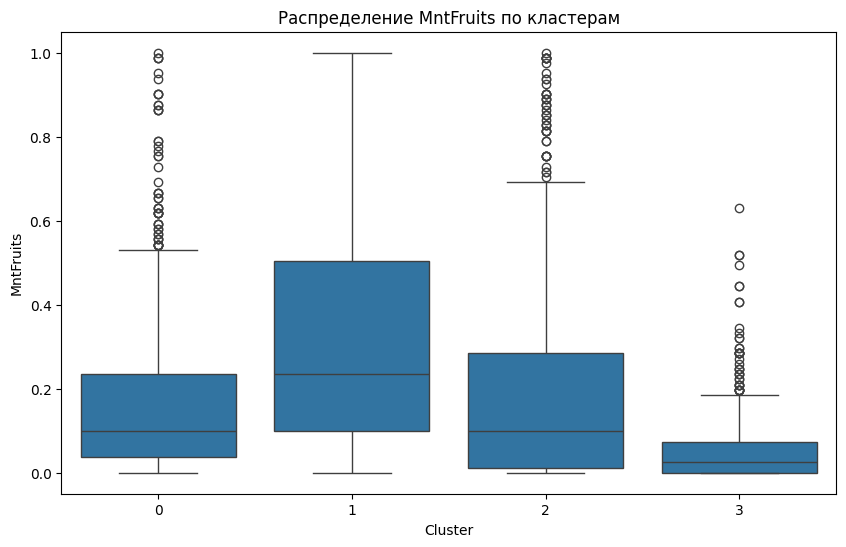

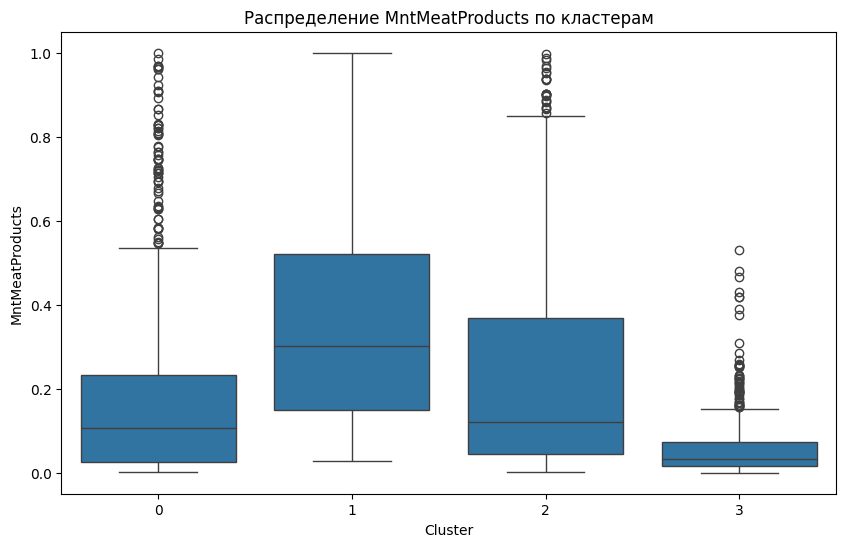

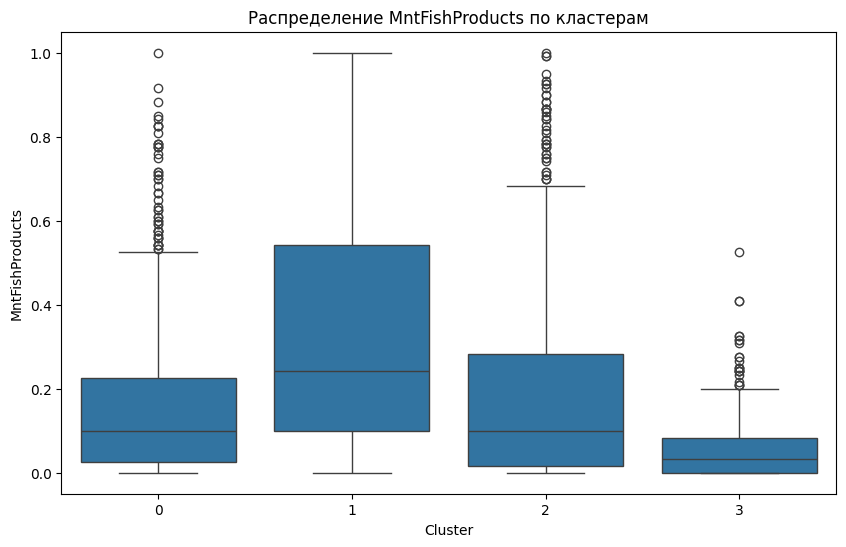

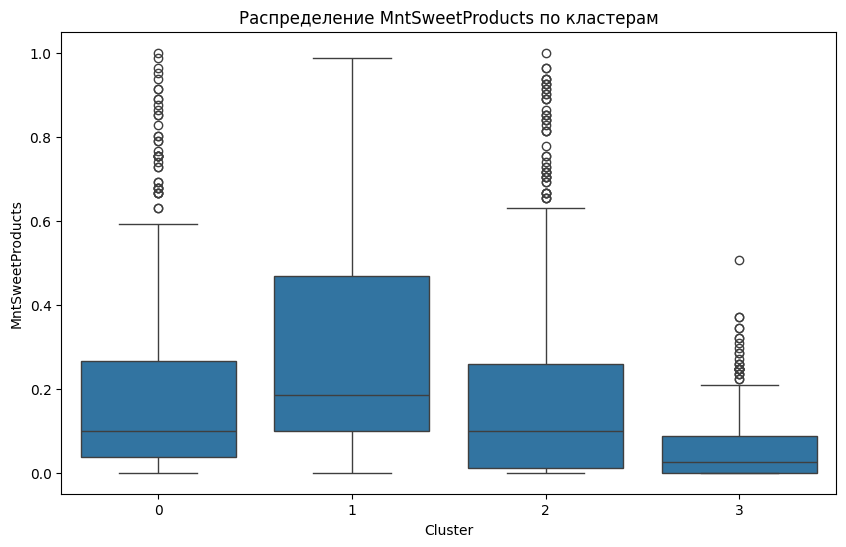

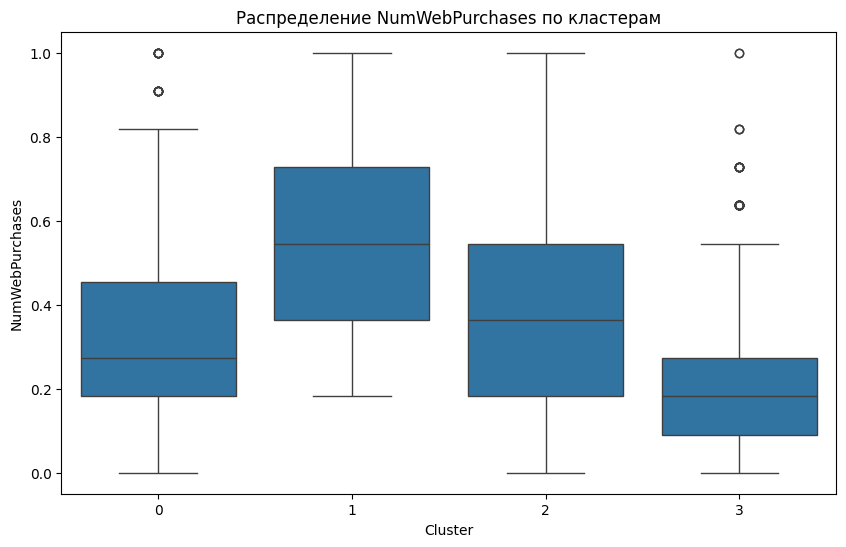

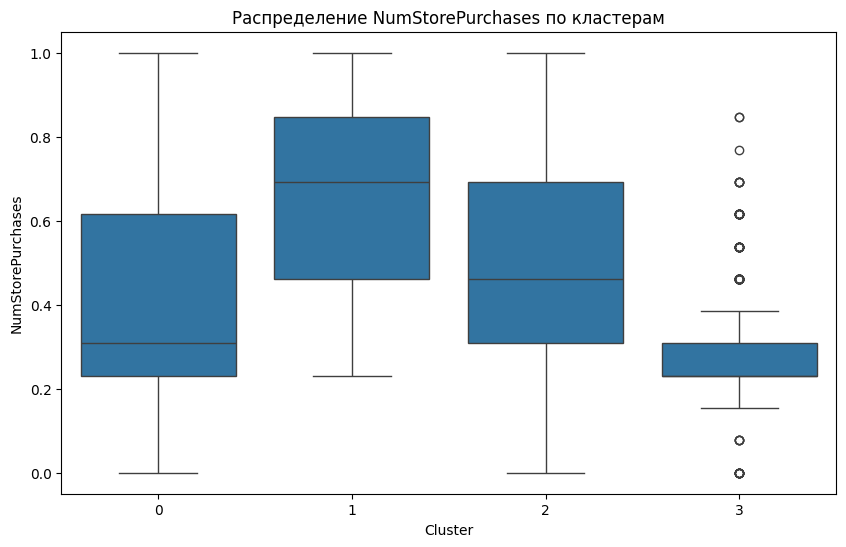

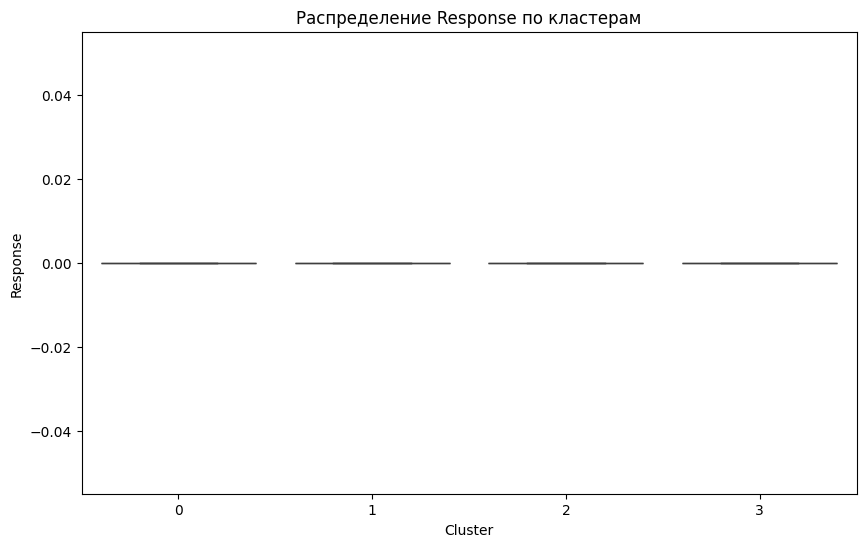

In [44]:
# Удаляем колонку 'Cluster' для построения визуализации
df_without_cluster = df.drop(columns=['Cluster'])

# Визуализация каждого признака по кластерам
for column in df_without_cluster.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Cluster', y=column, data=df)
    plt.title(f'Распределение {column} по кластерам')
    plt.show()


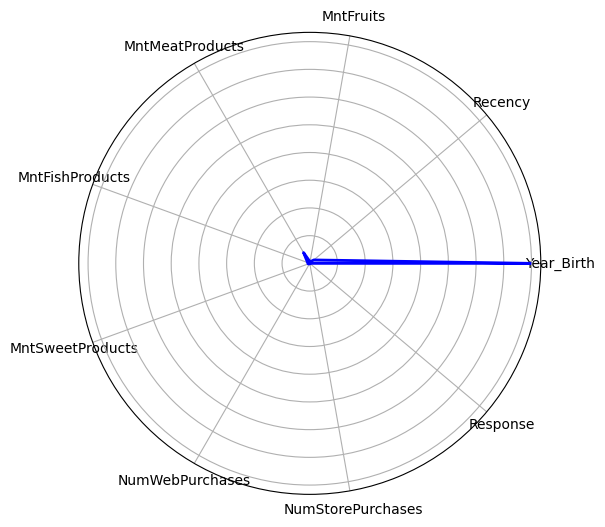

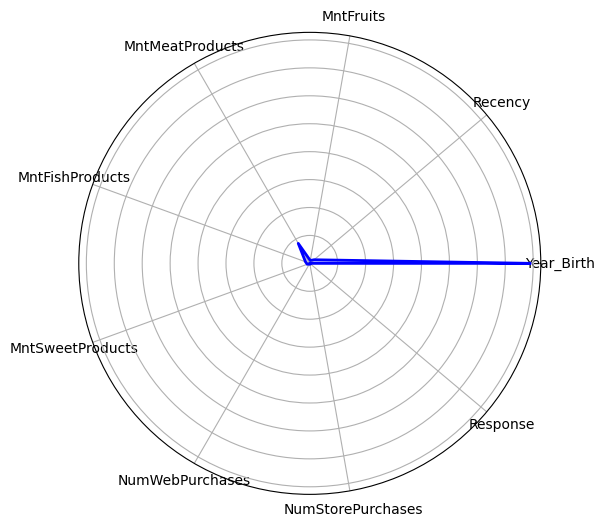

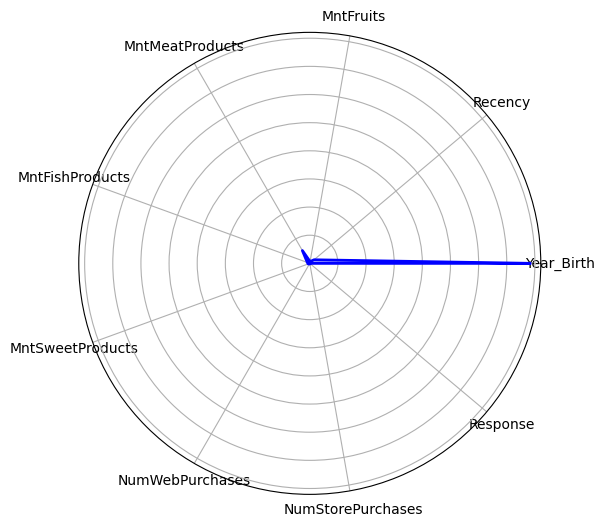

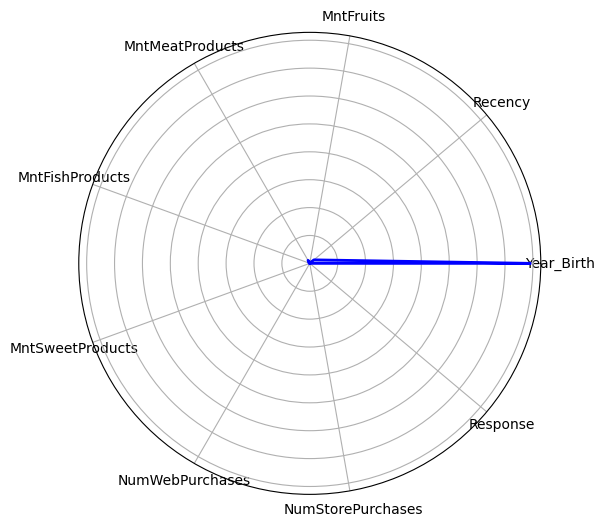

In [45]:
def create_radar_chart(data, labels):
    # Углы для графика
    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    
    # Убедитесь, что график замыкается
    data = data.flatten().tolist()
    data += data[:1]
    angles += angles[:1]

    # Построение графика
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.fill(angles, data, color='blue', alpha=0.25)
    ax.plot(angles, data, color='blue', linewidth=2)

    # Настройка меток
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)

# Пример использования
for index, row in centroids_df.iterrows():
    create_radar_chart(row.values, centroids_df.columns)


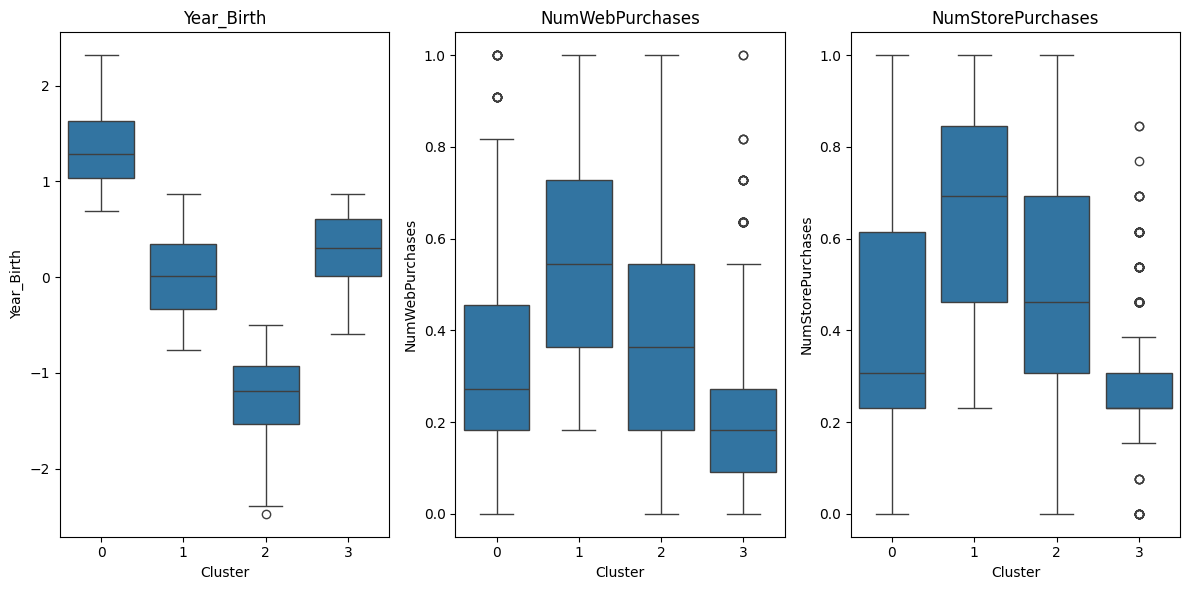

In [46]:
# Дополнительные визуализации для различий между кластерами
plt.figure(figsize=(12, 6))

# Используйте enumerate, чтобы получить индекс и название столбца
for i, column in enumerate(['Year_Birth', 'NumWebPurchases', 'NumStorePurchases']):
    plt.subplot(1, 3, i + 1)  # Указываем i + 1 для индексации подграфиков
    sns.boxplot(x='Cluster', y=column, data=df)
    plt.title(column)

plt.tight_layout()
plt.show()

## Как отправить работу на проверку

Скачайте файл с заданием в материалах, откройте его через Jupyter Notebook и выполните задания. Сохраните изменения при помощи опции Save and Checkpoint из вкладки меню File или кнопки Save and Checkpoint на панели инструментов. Отправьте через форму ниже итоговый файл Jupyter Notebook (.ipynb) или ссылку на него.